### 1. Реализовать персональный топ  - принимает на вход пол и локацию, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла

Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

### 3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов

В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок

Коллаборативную фильтрацию реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл.

Для Content-based, Коллаборативной фильтрации, Матричной Факторизации реализовать U2I и I2I рекомендации

### Примечание:

Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации
Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц)
Рейтинг книг обязательно нужно учитывать

Не забываем также предобработать данные - выкинуть выбросы-пользователей и выбросы-книги.

# Жесткий дедлайн - 12 мая

Выводить в качестве рекомендаций лучше названия книг, картинки (если они есть) и соответствующие метрики близости.
Присылать в виде ноутбука


In [118]:
!pip install lightfm

In [119]:
import numpy as np
import pandas as pd
import tqdm
import re
from lightfm import LightFM
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
import re

In [120]:
!mkdir ./data

mkdir: cannot create directory ‘./data’: File exists


In [121]:
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Book-Ratings.csv -O ./data/BX-Book-Ratings.csv
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Books.csv -O ./data/BX-Books.csv
!wget https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Users.csv -O ./data/BX-Users.csv

--2021-05-12 19:00:01--  https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Book-Ratings.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30682276 (29M) [text/plain]
Saving to: ‘./data/BX-Book-Ratings.csv’

./data/BX-Book-Rati 100%[===================>]  29.26M   123MB/s    in 0.2s    

2021-05-12 19:00:01 (123 MB/s) - ‘./data/BX-Book-Ratings.csv’ saved [30682276/30682276]

--2021-05-12 19:00:02--  https://raw.githubusercontent.com/vadim0912/MLbase_2021_spring/main/lecture07/HW_files/BX-Books.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.

In [122]:
books = pd.read_csv("./data/BX-Books.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
interactions = pd.read_csv("./data/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

In [124]:
interactions = interactions[interactions["Book-Rating"] != 0]

In [125]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [126]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [127]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [128]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [129]:
users = pd.read_csv('./data/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

In [130]:
users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [131]:
interactions.head()

User-ID        ISBN  Book-Rating  user_num  books_num
5       86583  3404139178            9         8         18
6       86583  3453061187            8        13         18
13      86583  3426609061            7         8         18
8555    16877  038550120X            9        81         10
8556    16877  034539657X            7        26         10

In [132]:
books.head()

ISBN  ...                                        Image-URL-L
0  0195153448  ...  http://images.amazon.com/images/P/0195153448.0...
1  0002005018  ...  http://images.amazon.com/images/P/0002005018.0...
2  0060973129  ...  http://images.amazon.com/images/P/0060973129.0...
3  0374157065  ...  http://images.amazon.com/images/P/0374157065.0...
4  0393045218  ...  http://images.amazon.com/images/P/0393045218.0...

[5 rows x 8 columns]

In [133]:
user_meets

User-ID  books_num
0            8          7
1            9          1
2           10          1
3           12          1
4           14          3
...        ...        ...
77800   278846          1
77801   278849          1
77802   278851         14
77803   278852          1
77804   278854          6

[77805 rows x 2 columns]

user_num - сколько человек купило книгу  
book_num - сколько книг купил человек


In [134]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [135]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [136]:
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [137]:
interactions.head()

User-ID        ISBN  ...  product_id    vid
0    86583  3404139178  ...       10397   3445
1   132500  3404139178  ...       10397   5248
2    66483  3404139178  ...       10397   2622
3   276866  3404139178  ...       10397  10887
4   106534  3404139178  ...       10397   4228

[5 rows x 9 columns]

In [138]:
books

ISBN  ...                                        Image-URL-L
0       0195153448  ...  http://images.amazon.com/images/P/0195153448.0...
1       0002005018  ...  http://images.amazon.com/images/P/0002005018.0...
2       0060973129  ...  http://images.amazon.com/images/P/0060973129.0...
3       0374157065  ...  http://images.amazon.com/images/P/0374157065.0...
4       0393045218  ...  http://images.amazon.com/images/P/0393045218.0...
...            ...  ...                                                ...
271355  0440400988  ...  http://images.amazon.com/images/P/0440400988.0...
271356  0525447644  ...  http://images.amazon.com/images/P/0525447644.0...
271357  006008667X  ...  http://images.amazon.com/images/P/006008667X.0...
271358  0192126040  ...  http://images.amazon.com/images/P/0192126040.0...
271359  0767409752  ...  http://images.amazon.com/images/P/0767409752.0...

[271360 rows x 8 columns]

In [139]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))

In [140]:
print(csr_rates)

  (3445, 10397)	9
  (5248, 10397)	10
  (2622, 10397)	10
  (10887, 10397)	9
  (4228, 10397)	6
  (6225, 10397)	9
  (3445, 10495)	8
  (1397, 10495)	9
  (4105, 10495)	8
  (101, 10495)	6
  (9402, 10495)	8
  (5446, 10495)	9
  (10236, 10495)	7
  (3445, 10428)	7
  (1410, 10428)	2
  (4901, 10428)	4
  (10775, 10428)	10
  (3350, 10428)	2
  (6807, 10428)	7
  (593, 3452)	9
  (753, 3452)	6
  (770, 3452)	7
  (823, 3452)	10
  (1112, 3452)	7
  (1273, 3452)	8
  :	:
  (6299, 10679)	7
  (10843, 7247)	8
  (5440, 10705)	2
  (755, 10705)	9
  (6807, 10414)	8
  (8825, 1678)	10
  (368, 8621)	5
  (6518, 10702)	7
  (661, 5639)	7
  (2542, 5154)	5
  (7883, 7079)	6
  (10764, 7079)	5
  (879, 7079)	8
  (2682, 7079)	10
  (3381, 10510)	9
  (7234, 10541)	10
  (5589, 10541)	5
  (7498, 6211)	7
  (1271, 1054)	10
  (9746, 1054)	8
  (1035, 9478)	10
  (8112, 10209)	9
  (8754, 10138)	8
  (3740, 276)	9
  (2964, 9496)	8


In [141]:
for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
    if "David Copperfield" in j:
        print("idx:", i, "\tBook Title:", j)

idx: 10174 	Book Title: David Copperfield (Wordsworth Classics)
idx: 1074 	Book Title: David Copperfield (Penguin Classics)


In [142]:
users

User-ID                            Location   Age
0             1                  nyc, new york, usa   NaN
1             2           stockton, california, usa  18.0
2             3     moscow, yukon territory, russia   NaN
3             4           porto, v.n.gaia, portugal  17.0
4             5  farnborough, hants, united kingdom   NaN
...         ...                                 ...   ...
278853   278854               portland, oregon, usa   NaN
278854   278855  tacoma, washington, united kingdom  50.0
278855   278856           brampton, ontario, canada   NaN
278856   278857           knoxville, tennessee, usa   NaN
278857   278858                dublin, n/a, ireland   NaN

[278858 rows x 3 columns]

### 1)Предобработка данных

Сначала чищу датафрейм books, в нем просто убираю строки с неверными ISBN

In [143]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

На мой взгляд, отстутсвие некоторых данных (выше) не критично, тк важными данными являются ISBN и название, поэтому никак не обрабатываю NaN. Хотя мб в дальнейшем я удалю строчки с пропущенными данными отсюда. Пока просто иду дальше.

In [144]:
books.shape

(271360, 8)

In [145]:
# ISBN книг в исходных данных 10 значный и полностью состоит из цифр
# проверяю, что существуют строки, в которых ISBN некорректен (деление на 1000 чтобы сократить время выполнения)
for i in range(books.shape[0]//1000):
  if not re.match('\d{10}', books.ISBN[i]):
    print(i,books.ISBN[i])


9 074322678X
11 080652121X
40 038078243X
41 055321215X
42 067176537X
48 042518630X
66 042511774X
82 087113375X
105 067976397X
139 038572179X
157 044651747X
164 039575514X
188 342311360X
215 038076654X
232 051513290X
243 140003180X
244 155874262X
253 006102063X
256 006052779X
268 034543191X


In [146]:
books.drop(index = books[books.ISBN.map(lambda x: not bool(re.match('\d{10}', x)))].index, inplace = True)

In [147]:
books.shape

(249030, 8)

Также удаляю книги с неверными ISBN из interactions

In [148]:
interactions.shape

(110519, 9)

In [149]:
interactions.drop(index = interactions[interactions.ISBN.map(lambda x: not bool(re.match('\d{10}', x)))].index, inplace = True)

In [150]:
interactions.shape

(101068, 9)

In [151]:
interactions

User-ID        ISBN  ...  product_id    vid
0         86583  3404139178  ...       10397   3445
1        132500  3404139178  ...       10397   5248
2         66483  3404139178  ...       10397   2622
3        276866  3404139178  ...       10397  10887
4        106534  3404139178  ...       10397   4228
...         ...         ...  ...         ...    ...
110514    27551  0849912970  ...        9478   1035
110515   206652  1860465811  ...       10209   8112
110516   223525  1588720284  ...       10138   8754
110517    94153  0060652926  ...         276   3740
110518    74782  0868246786  ...        9496   2964

[101068 rows x 9 columns]

Далее удаляю пользователей, которые не попали в interactions. Не попали они ,например, по причине низкой оценки книги (0). 

In [152]:
users.shape

(278858, 3)

In [153]:
unique_list_usr_inter = interactions['User-ID'].unique()

In [154]:
users.drop(index = users[users['User-ID'].map(lambda x: x not in unique_list_usr_inter)].index, inplace = True)

In [155]:
users

User-ID                              Location   Age
7             8              timmins, ontario, canada   NaN
98           99              franktown, colorado, usa  42.0
113         114           ligonier, pennsylvania, usa  57.0
241         242  neuffen, baden-wuerttemberg, germany  37.0
242         243           arden hills, minnesota, usa   NaN
...         ...                                   ...   ...
278667   278668                 madrid, madrid, spain  48.0
278693   278694              montgomery, alabama, usa  57.0
278842   278843          pismo beach, california, usa  28.0
278850   278851                    dallas, texas, usa  33.0
278853   278854                 portland, oregon, usa   NaN

[10871 rows x 3 columns]

In [156]:
users.isna().sum()

User-ID        0
Location       0
Age         3146
dtype: int64

Далее буду парсить дату на страну, штат (регион), город. 

In [157]:
loc = users.Location.str.split(', ', n=2, expand= True)
loc.rename(columns = {0:'city',1:'state',2:'country'}, inplace = True)

In [158]:
loc

city               state  country
7           timmins             ontario   canada
98        franktown            colorado      usa
113        ligonier        pennsylvania      usa
241         neuffen  baden-wuerttemberg  germany
242     arden hills           minnesota      usa
...             ...                 ...      ...
278667       madrid              madrid    spain
278693   montgomery             alabama      usa
278842  pismo beach          california      usa
278850       dallas               texas      usa
278853     portland              oregon      usa

[10871 rows x 3 columns]

In [159]:
users.drop('Location',axis = 1, inplace = True)

In [160]:
users = pd.concat([users,loc], axis =1 ,ignore_index= True)

In [161]:
users.head()

0     1            2                   3        4
7      8   NaN      timmins             ontario   canada
98    99  42.0    franktown            colorado      usa
113  114  57.0     ligonier        pennsylvania      usa
241  242  37.0      neuffen  baden-wuerttemberg  germany
242  243   NaN  arden hills           minnesota      usa

In [162]:
users.rename(columns = {0:'User-ID',1:'Age',2:'city',3:'state',4:'country'}, inplace = True)

In [163]:
users[users.state == ',']

User-ID   Age             city state country
928         929  36.0  king of prussia     ,    None
1130       1131  22.0         berkeley     ,    None
2441       2442  25.0           torino     ,    None
3922       3923   NaN           vienna     ,    None
5475       5476   NaN          chester     ,    None
...         ...   ...              ...   ...     ...
273070   273071   NaN          kelowna     ,    None
273109   273110  51.0             arco     ,    None
273189   273190  71.0    coconut grove     ,    None
273634   273635   NaN          raleigh     ,    None
276537   276538  26.0          cologne     ,    None

[299 rows x 5 columns]

In [164]:
users.isna().sum()

User-ID       0
Age        3146
city          0
state         0
country     423
dtype: int64

In [165]:
users.shape

(10871, 5)

In [166]:
users.dropna(subset=['country'],inplace = True)

In [167]:
# топ 60 штатов по пользователям
# видно, что есть невалидные данные типа n/a и пустая строка для штата
users.state.value_counts()[0:60]

california             1060
texas                   454
ontario                 450
new york                358
florida                 346
illinois                322
pennsylvania            296
washington              290
virginia                267
british columbia        239
england                 235
michigan                222
oregon                  216
ohio                    214
missouri                205
massachusetts           202
north carolina          194
minnesota               176
georgia                 165
new jersey              162
maryland                150
n/a                     143
alberta                 134
colorado                132
wisconsin               128
arizona                 126
indiana                 108
nordrhein-westfalen     106
tennessee               105
kentucky                 91
connecticut              90
south carolina           82
alabama                  80
iowa                     79
new mexico               74
new south wales     

In [168]:
# чищу строки с невалидными штатами
users.drop(index = users[users.state == ''].index,inplace = True)
users.drop(index = users[users.state == 'n/a'].index, inplace = True)
# так же удаляю невалидные штаты, которые нашел позже при работе с данными
users.drop(index = users[users.state == '<foreign>'].index, inplace = True)
users.drop(index = users[users.state == f'\\"n/a\"'].index, inplace = True)
users.drop(index = users[users.state == '_'].index, inplace = True)


Аналогичные действия делаю для стран и городов.

In [169]:
users.country.value_counts()[0:60]

usa                               7210
canada                            1031
germany                            412
united kingdom                     379
australia                          218
spain                              198
france                             131
portugal                            89
italy                               89
netherlands                         61
switzerland                         56
malaysia                            53
austria                             43
new zealand                         38
finland                             25
romania                             15
ireland                             15
brazil                              14
philippines                         12
sweden                              12
japan                               12
singapore                            9
england, united kingdom              8
china                                7
norway                               6
mexico                   

In [170]:
users.city.value_counts()[0:60]

toronto           130
chicago            94
portland           90
san diego          84
seattle            80
london             73
vancouver          72
houston            70
austin             64
new york           64
ottawa             64
san francisco      53
minneapolis        53
calgary            51
sydney             51
barcelona          49
los angeles        48
cincinnati         41
victoria           41
edmonton           40
albuquerque        38
st. louis          37
richmond           36
san antonio        34
philadelphia       33
tucson             33
hamburg            33
atlanta            32
san jose           31
paris              30
olympia            30
manchester         30
dallas             29
louisville         29
rochester          29
pittsburgh         29
halifax            29
melbourne          29
orlando            28
jacksonville       27
brooklyn           27
washington         26
sacramento         26
las vegas          25
denver             25
lisboa    

Для городов и стран все более менее норм, поэтому ничего не удаляю. 

Далее группирую пользователей по штатам и заполняю NaN в Age.

In [171]:
users.isna().sum()

User-ID       0
Age        2864
city          0
state         0
country       0
dtype: int64

In [172]:
# заполняю средним значение по штату
users.Age = users.groupby(users.state)['Age'].transform(lambda x: x.fillna(x.median()))
# не все пропуски удалось заполнить средним по штату, заполняю дальше средним по стране
users.Age = users.groupby(users.country)['Age'].transform(lambda x: x.fillna(x.median()))

In [173]:
users.isna().sum()

User-ID    0
Age        9
city       0
state      0
country    0
dtype: int64

Оставшиеся NaN значения удаляю.

In [174]:
users.dropna(subset=['Age'],inplace = True)

In [175]:
users.isna().sum()

User-ID    0
Age        0
city       0
state      0
country    0
dtype: int64

Далее удаляю невалидный возраст >100 и <=3

In [176]:
users.drop(index = users[users.Age > 100].index, inplace = True)

In [177]:
users.drop(index = users[users.Age <= 3].index, inplace = True)

Следующим шагом чищу датафрейм взаимоедйствий, потому что удалились некоторые юзеры из датасета юзерс.

In [178]:
usr_unique_id = users['User-ID'].unique()

In [179]:
interactions.shape

(101068, 9)

In [180]:
interactions.drop(index = interactions[interactions['User-ID'].map(lambda x: x not in usr_unique_id)].index,inplace = True)

In [181]:
interactions.shape

(95653, 9)

### 2) Персональный топ - не сделал

### 3) Кластеризация


Кластеризую пользователей по их оценкам книг (пользователей брал только из interactions, хотя по факту в юзерс они такие же, потому что я чистил датафрейм пользователей и оставил там только тех, кто вошел в interactions)

In [182]:
books_id = interactions.product_id.unique()
users_id = interactions.vid.unique()

In [183]:
zer = np.zeros((len(users_id),len(books_id)))

In [184]:
new_df = pd.DataFrame(zer,columns = books_id)

In [185]:
new_df.shape

(10188, 9841)

In [186]:
new_df.insert(0,column = 'vid',value = users_id)



In [187]:
for i in range(new_df.shape[0]):
  sub_df = interactions[interactions.vid == new_df.vid[i]]
  for j in sub_df.index:
    book = sub_df['product_id'][j]
    rating = sub_df['Book-Rating'][j]
    new_df[book][i] = rating

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages

In [188]:
new_df #датафрейм с оценками пользователя к каждой книге из interactions

vid  10397  10495  10428  8477  ...  9478  10209  10138  276  9496
0       2622   10.0    0.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   0.0
1      10887    9.0    0.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   0.0
2       4228    6.0    0.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   0.0
3       6225    9.0    0.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   0.0
4       1397    0.0    9.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   0.0
...      ...    ...    ...    ...   ...  ...   ...    ...    ...  ...   ...
10183    879    0.0    0.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   0.0
10184   7498    0.0    0.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   0.0
10185   8112    0.0    0.0    0.0   0.0  ...   0.0    9.0    0.0  0.0   0.0
10186   8754    0.0    0.0    0.0   0.0  ...   0.0    0.0    8.0  0.0   0.0
10187   2964    0.0    0.0    0.0   0.0  ...   0.0    0.0    0.0  0.0   8.0

[10188 rows x 9842 columns]

In [189]:
df_to_clust = new_df.iloc[:,1:]

In [190]:
df_to_clust

10397  10495  10428  8477   8930   ...  9478   10209  10138  276    9496 
0       10.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
1        9.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
2        6.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
3        9.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
4        0.0    9.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
...      ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
10183    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
10184    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
10185    0.0    0.0    0.0    0.0    0.0  ...    0.0    9.0    0.0    0.0    0.0
10186    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    8.0    0.0    0.0
10187    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    8.0

[10188 rows x 9841 columns]

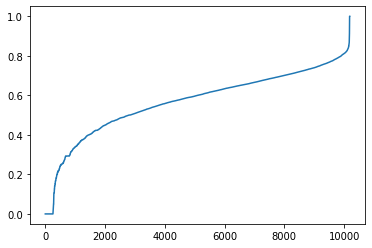

In [191]:
#фактически датафрейм уже векторизован
# координаты ветора - оценки соответствующей книги
from sklearn.neighbors import NearestNeighbors
min_pts = 9
neighbors = NearestNeighbors(n_neighbors=min_pts, metric='cosine',n_jobs =-1)
neighbors.fit(df_to_clust)
d, idx = neighbors.kneighbors(df_to_clust, return_distance=True)
dist = d[:, 1]
dist = np.sort(dist)
plt.plot(dist)

In [192]:
from sklearn.cluster import  DBSCAN
dbscan = DBSCAN(eps=0.75, min_samples=min_pts, metric='cosine')
dbscan.fit(df_to_clust)
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

In [193]:
new_df['clust_labels'] = dbscan.labels_

In [194]:
# убираю пользователей, которые кластеризовались как выбросы
final_df = new_df[new_df['clust_labels'] != -1]

In [195]:
final_df

vid  10397  10495  10428  8477  ...  10209  10138  276  9496  clust_labels
0       2622   10.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             0
1      10887    9.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             0
2       4228    6.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             0
3       6225    9.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             0
4       1397    0.0    9.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             0
...      ...    ...    ...    ...   ...  ...    ...    ...  ...   ...           ...
10173   1938    0.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             8
10177    943    0.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             8
10178   4213    0.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             8
10179   5786    0.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             0
10181    755    0.0    0.0    0.0   0.0  ...    0.0    0.0  0.0   0.0             0

[8171 rows x 9843 columns]

In [196]:
final_df = final_df.iloc[:,final_df.columns.isin(['vid','clust_labels'])]

In [197]:
final_df[final_df['clust_labels'] == 9]

vid  clust_labels
3448   7004             9
10009  2517             9

Пытался подбирать min_pts и eps, но всегда получаю что один кластер на несколько порядков больше другого, те толку от такой кластеризации особо нет. Возможно, в данных действительно существует один большой кластер похожих пользователей. Тем не менее, посчитаю топ для каждого из кластеров.

In [198]:
usr_uniq=final_df.vid.unique()
int_copy = interactions.copy()

In [202]:
int_copy.drop(index = int_copy[int_copy['vid'].map(lambda x: x not in usr_uniq)].index, inplace = True)

In [203]:
vid_clus_lab_dict = final_df.iloc[:,:].to_dict()

In [204]:
# каждому в таблице интеракшенов поставить лэйбл
z = np.zeros(int_copy.shape[0])
int_copy.insert(len(int_copy.columns),column='clust_labels',value = z)

In [205]:
for i in vid_clus_lab_dict['clust_labels'].keys():
  sub_df = int_copy[int_copy.vid == i]
  for j in sub_df.index:
    int_copy.clust_labels[j] = vid_clus_lab_dict['clust_labels'][i]


Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [241]:
rated_book_df = int_copy.groupby(['clust_labels','product_id'])['Book-Rating'].mean()
av_rating = rated_book_df.values
rated_book_df = rated_book_df.index.to_frame(index=False)
rated_book_df['av_rating'] = av_rating
rated_book_df.sort_values(by = ['clust_labels','av_rating'], ascending=False,inplace = True)
rated_book_df.reset_index(drop=True)

clust_labels  product_id  av_rating
0              9.0        4577       10.0
1              9.0        4579       10.0
2              9.0         705        9.0
3              9.0        4580        7.0
4              8.0        2840       10.0
...            ...         ...        ...
9594           0.0        1074        1.0
9595           0.0        4115        1.0
9596           0.0        8442        1.0
9597           0.0        9469        1.0
9598           0.0       10599        1.0

[9599 rows x 3 columns]

In [302]:
def recomendation(vid):
    clust_label = int_copy[int_copy.vid == vid]['clust_labels'].values[0]
    books = rated_book_df[rated_book_df.clust_labels == clust_label]['product_id'][:10]
    fig = plt.figure(figsize=(20, 10))
    for i,book in enumerate(books):
      response = requests.get(int_copy[int_copy.product_id == book]['picture_url'].values[0])
      img = Image.open(BytesIO(response.content))
      a = fig.add_subplot(2,5,i+1)
      a.title.set_text(int_copy[int_copy.product_id == book]['Book-Title'].values[0])
      plt.imshow(img)
      plt.axis('off')
    plt.show()


In [312]:
int_copy[int_copy.clust_labels == 0].head(1)

User-ID        ISBN  Book-Rating  ...  product_id   vid clust_labels
2    66483  3404139178           10  ...       10397  2622          0.0

[1 rows x 10 columns]

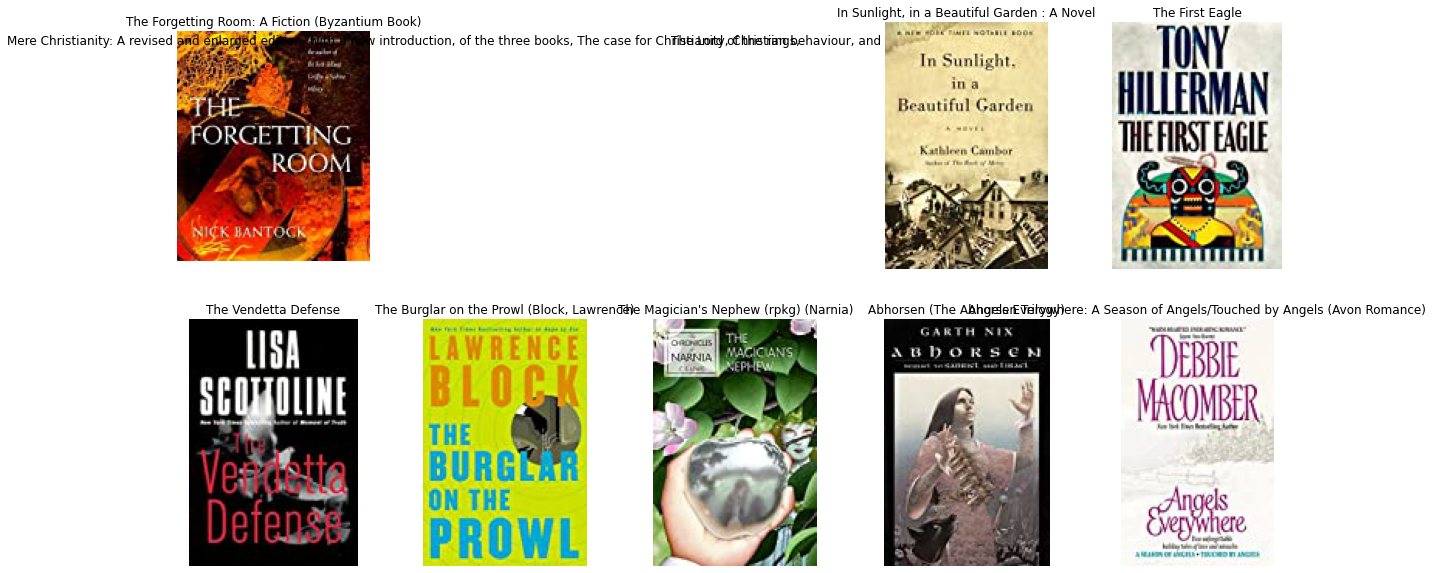

In [303]:
# кластер 0
recomendation(2622)

In [313]:
int_copy[int_copy.clust_labels == 1].head(1)

User-ID        ISBN  Book-Rating  ...  product_id   vid clust_labels
5788    51742  0743412028            8  ...        8582  2040          1.0

[1 rows x 10 columns]

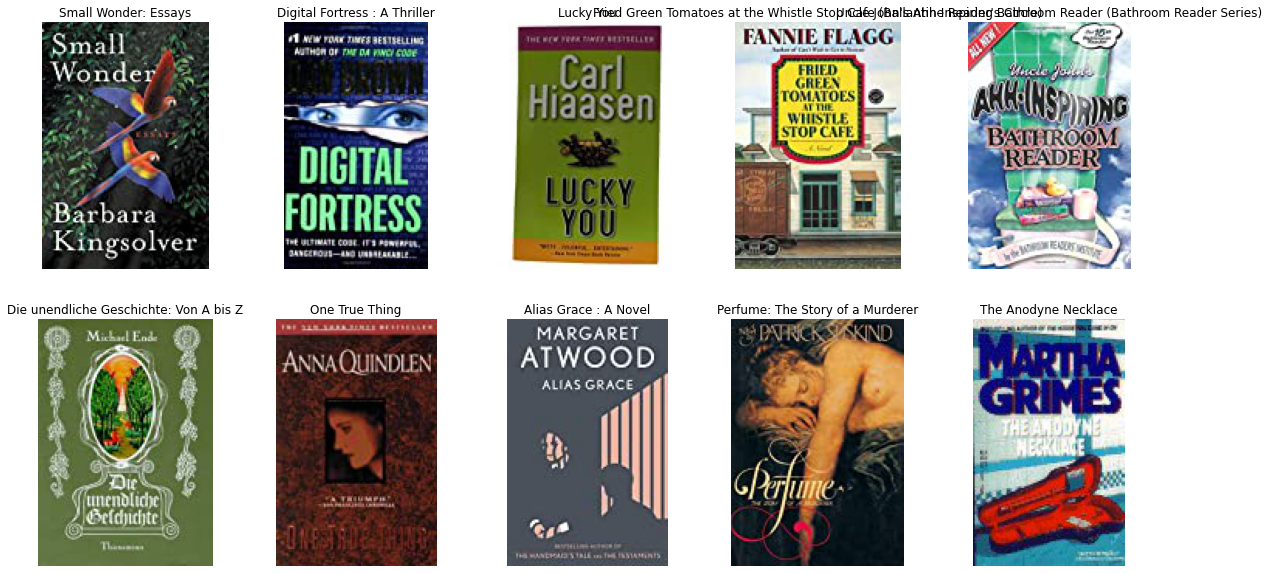

In [311]:
# кластер 1
recomendation(2040)

Здесь каждому пользователю рекомендуется книги, популярные для кластера, к которому относится этот пользователь. По книгам сложно интерпретировать каждый кластер, поэтому, как я говорил ранее, такая кластеризаци ничего толкового не дала (ну или я неправильно ее сделал).

### 4) Совстречаемость

In [314]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [315]:
class Recomendations():
    def __init__(self, Int):
        # Создаём словарь для того, чтобы по product_id возвращать url товара
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id","Book-Rating"]].drop_duplicates() # добавил рейтинг книг
        # Для каждого пользователя собираем товары, с которыми он взамиодействовал
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        # Считаем число товаров, с которыми взаимодействовал каждый пользователь и записываем в колонку prod_num
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        # Фильтруем пользователей, взаимодействовавших с одним товаром
        user_products = user_products[user_products["prod_num"] > 1]
        
        # Заводим словарь под товары
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                      # если я правильно понял задание, то в качестве меры релевантности здесь используется полусумма рейтингов
                      rating_j = Int[(Int.vid == i[0])&(Int.product_id == i[1][j])]['Book-Rating'].iloc[0]
                      rating_k = Int[(Int.vid == i[0])&(Int.product_id == i[1][k])]['Book-Rating'].iloc[0]
                      try:
                        cooc[str(i[1][j]) + "_" + str(i[1][k])] += (rating_j + rating_k)/2
                      except:
                          cooc[str(i[1][j]) + "_" + str(i[1][k])] = (rating_j + rating_k)/2
        cooc_list = []
        for i, j in cooc.items():
            # Если товары встетились вместе больше одного раза, то добавляем в список
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [316]:
# беру не весь датафрейм взаимодействий, чтобы совстречаемость считалась за приемлемое время
cooc_rec = Recomendations(interactions[0:10000])
cooc_rec.coocurrency_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [318]:
cooc_rec.cooc_rec.sort_values("measure", ascending=False)

item1 item2  measure
27     7035  4216    547.5
17     4216  7035    547.5
23     4226  4216    510.0
16     4216  4226    510.0
29     7035  4226    366.0
...     ...   ...      ...
2097   4079   172      3.0
26688  7755  5105      2.5
20270   640  5852      2.5
26691  5105  7755      2.5
20271  5852   640      2.5

[26924 rows x 3 columns]

Для товара


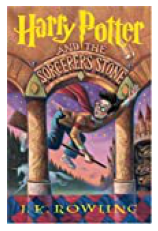

Такие рекомендации


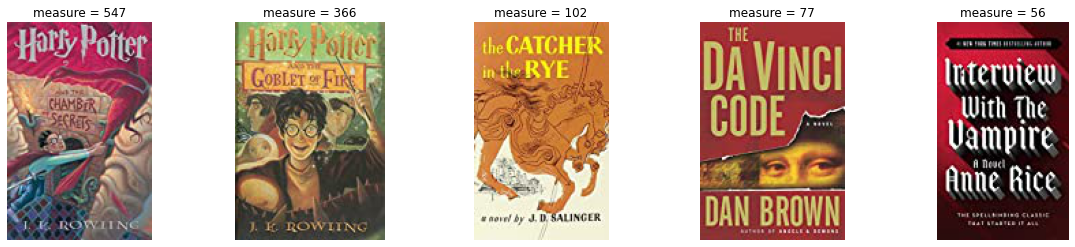

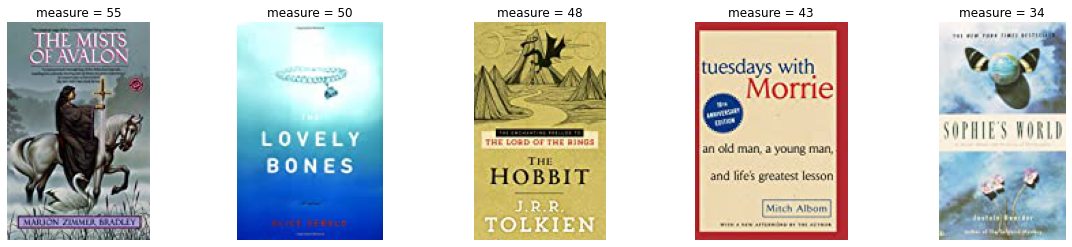

In [319]:
cooc_rec.get_rec(7035)

Видно, что для книги про Гарри Поттера рекомендуются книги из этой же серии (их 2 только потому, что я считаю совсречаемость на урезанном массиве interactions в целях экономии времени, если запустить на всех данных, то книг про гарри поттера в рекомендации будет больше)

### 5) Content-based

In [ ]:
class Content_Based():
    def __init__(self, items, interactions):
        self.items = items
        self.interactions = interactions.drop_duplicates()
        self.content_dict = {}
        for i, j in enumerate(items["Image-URL-M"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}
        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.items['Book-Title']]
        #build vocabulary and train model
        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        self.items_embs = np.zeros((len(item_description), 200))
        for i in range(self.items_embs.shape[0]):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])


    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]
        user_vector = " ".join(ui["Book-Title"])
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["picture_url"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [ ]:
CB = Content_Based(books, interactions)

In [ ]:
CB.get_items_representation()

Для товара


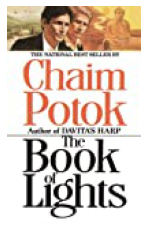

Такие рекомендации


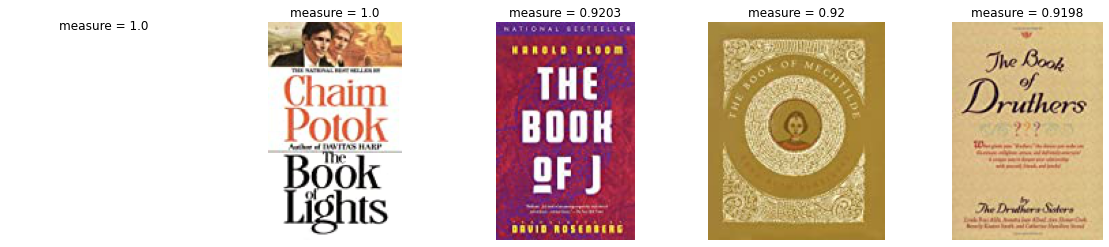

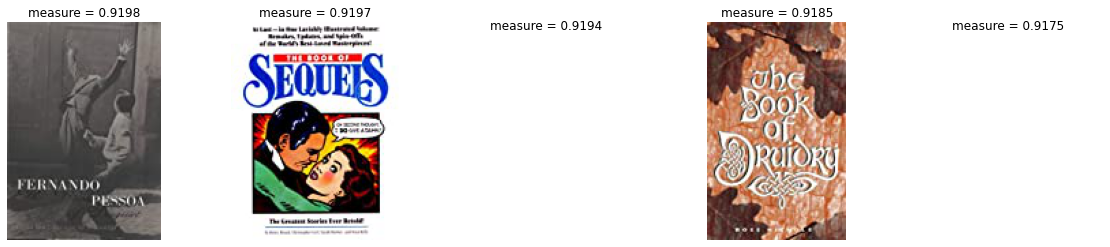

In [ ]:
CB.get_rec_I2I(666)

Здесь видно, что порекомендовались книги у которых в названии присутствует "The book", тк в исходном названии это тоже было. На мой взгляд, такой подход для рекомендации книг неприменим (по факту я искал похожесть по названию, но название не всегда отражает содержание книги, поэтому такой рекомендации верить не стоит), если бы было краткое описание книги, тогда было бы лучше использовать его.

Для пользователя, который взаимодействовал с товарами


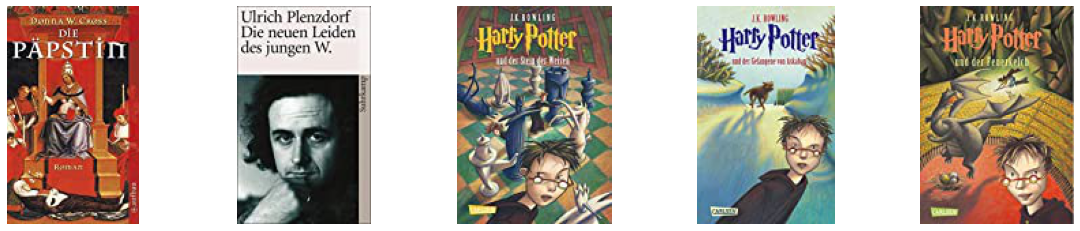

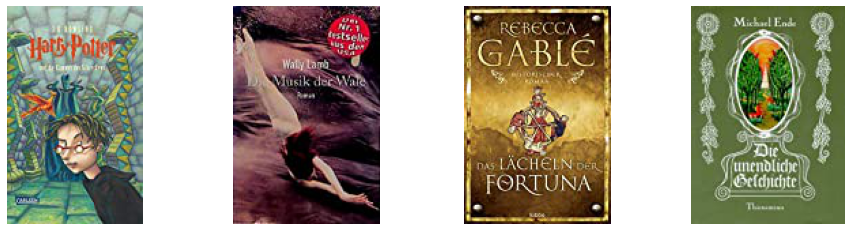

Такие рекомендации


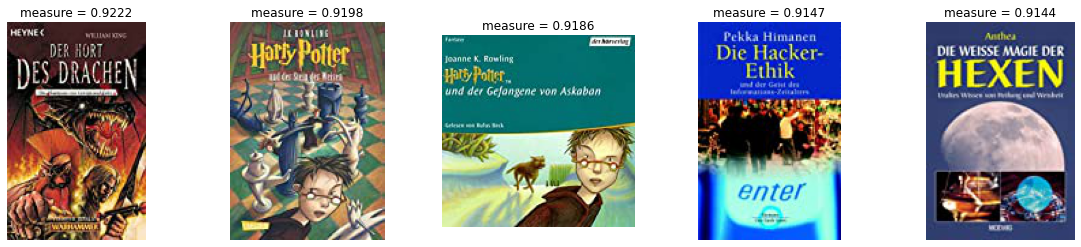

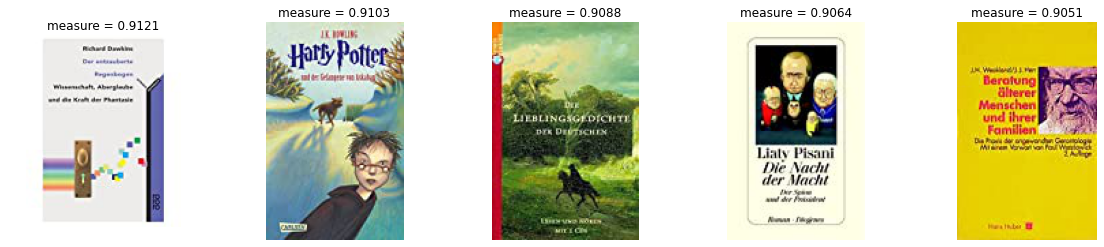

In [ ]:
CB.get_rec_U2I(2622)

Видно, что для пользователя который читал Гарри Поттера порекомендовались книги из этой серии и так же что то из фэнтези. Хотя странно, что наибольшая похожесть у книги про дракона. Мне кажется здесь сыграл факт, что пользователь взаимодействовал в большей степени с немецкими книгами (5/9), в названии которых присутствуют немецкие слова, а серия про гарри поттера вроде названа по-английски, поэтому так.

### 6,7) Матричная факторизация, коллаборативная фильтрация - не делал